# ОИАД. Лабораторная работа №4
Используйте набор данных datasets/famcs_students.csv

binary_cols = [ss, interest, weekend_study, bad_sleep, glasses, anime, study_form, literature]

Исползуйте целевую переменную y = binary_cols[N % 8], где N - номер в списке группы. Остальные переменные используйте в качестве признаков X (предикторов). Вы можете отобрать наиболее информативные (по вашему экспертному мнению) признаки, но не менее 5.

Необходимо построить несколько моделей бинарной классификации y по признакам X.

Разделите случайно исходные данные на 3 выборки:
- тренировочная (70%) - для определения параметров модели
- валидацонная (15%) - для подбора гиперпараметров модели
- тестовую (15%) - итоговая оценка качества

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
df = pd.read_csv('famcs_students.csv')

# Определение целевой переменной
N = 6
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
target_col = binary_cols[N % 8]

# Подготовка признаков и целевой переменной
features = ['age', 'height', 'cource', 'work_experience', 'score']
X = df[features].apply(pd.to_numeric, errors='coerce').fillna(0)
y = pd.get_dummies(df[target_col], drop_first=True).iloc[:, 0]

# Разделение на тренировочную, валидационную и тестовую выборки
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Целевая переменная: {target_col}")
print(f"Размеры выборок - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Целевая переменная: study_form
Размеры выборок - Train: (88, 5), Val: (19, 5), Test: (20, 5)


Для корректной оценки обобщающей способности моделей данные разделены на три независимые выборки. Тренировочная (70%) используется для обучения параметров моделей, валидационная (15%) - для подбора гиперпараметров, тестовая (15%) - для финальной оценки качества.

Результаты: В качестве целевой переменной выбрана 'study_form'. Использованы 5 числовых признаков: возраст, рост, курс, опыт работы и академический балл. Стратификация обеспечивает сохранение распределения классов во всех выборках.

### Задание 0. Тривиальный классификатор
Всегда выдает наиболее частый класс

In [22]:
most_frequent_class = y_train.mode()[0]
print(f"Наиболее частый класс в тренировочной выборке: {most_frequent_class}")

y_pred_trivial = np.full_like(y_test, most_frequent_class)

print("\nТРИВИАЛЬНЫЙ КЛАССИФИКАТОР")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_trivial):.4f}")

Наиболее частый класс в тренировочной выборке: False

ТРИВИАЛЬНЫЙ КЛАССИФИКАТОР
Accuracy:  0.7500


Тривиальный классификатор служит базовым уровнем (baseline) для сравнения. Если модель не превосходит его по качеству, она не имеет практической ценности для данной задачи.

Результаты: 
- лассификатор показывает accuracy = 0.7500, что означает доминирование одного класса в данных. 
- Наиболее частый класс - False (платная форма обучения).
- Тривиальный классификатор всегда говорит "платная форма".

### Задание 1. Наивный байесовский классификатор
Алгоритм реализуйте сами!

In [19]:
class NaiveBayesClassifier:
    def __init__(self): 
        self.class_priors = {}
        self.feature_params = {}
    
    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        for cls in np.unique(y):
            self.class_priors[cls] = np.mean(y == cls)
            X_cls = X[y == cls]
            self.feature_params[cls] = {
                'mean': X_cls.mean(axis=0),
                'std': X_cls.std(axis=0) + 1e-8
            }
    
    def predict_proba(self, X):
        X = np.array(X)
        probs = []
        for sample in X:
            class_probs = {}
            for cls, prior in self.class_priors.items():
                likelihood = prior
                means = self.feature_params[cls]['mean']
                stds = self.feature_params[cls]['std']
                for i, x in enumerate(sample):
                    exponent = np.exp(-((x - means[i]) ** 2) / (2 * stds[i] ** 2))
                    likelihood *= (1 / (np.sqrt(2 * np.pi) * stds[i])) * exponent
                class_probs[cls] = likelihood
            total = sum(class_probs.values())
            probs.append({cls: prob/total for cls, prob in class_probs.items()})
        return probs
    
    def predict(self, X): 
        return np.array([max(p.items(), key=lambda x: x[1])[0] for p in self.predict_proba(X)])

# Обучение и оценка
nb = NaiveBayesClassifier()
nb.fit(X_train_scaled, y_train)
y_pred_nb = nb.predict(X_test_scaled)

y_proba_nb = np.array([p[1] for p in nb.predict_proba(X_test_scaled)])

print("НАИВНЫЙ БАЙЕС")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_nb):.4f}")

НАИВНЫЙ БАЙЕС
Accuracy:  0.3000


Наивный Байес основан на теореме Байеса и предположении о независимости признаков. Для непрерывных данных используется гауссовское распределение. Алгоритм эффективен при большом количестве признаков и устойчив к шуму.

Формула Байеса:
P(класс | признаки) = P(признаки | класс) × P(класс) / P(признаки),
где
P(класс | признаки) — апостериорная вероятность (что нам нужно),
P(признаки | класс) — правдоподобие,
P(класс) — априорная вероятность класса,
P(признаки) — нормирующая константа.

Результаты: 
- Точность модели: 30.00%
- Модель работает ХУЖЕ случайного угадывания (50%)
- Модель работает ХУЖЕ тривиального классификатора (75%)
- Наивное предположение о независимости признаков не выполняется
- Выбранные признаки плохо подходят для этой модели
- Модель слишком часто предсказывает редкий класс (бюджет)
- Это худшая из рассмотренных моделей

Модель работает плохо потому что:
- Признаки слабо связаны с формой обучения (бюджет/платная)
- Наивное предположение о независимости не выполняется (например, возраст и курс связаны)
- Низкая точность - много ложных срабатываний (предсказывает "бюджет", когда студент платный)

Эти 5 признаков (возраст, рост, курс, опыт работы, средний балл) недостаточно информативны для предсказания формы обучения. Нужны другие признаки или более сложная модель.

### Задание 2. Метод k-ближайших соседей
Алгоритм реализуйте сами! Подберите оптимальный гиперпараметр k.

In [13]:
class KNNClassifier:
    def __init__(self, k=5): 
        self.k = k
    
    def fit(self, X, y): 
        self.X_train, self.y_train = np.array(X), np.array(y)
    
    def predict(self, X):
        X = np.array(X)
        predictions = []
        for x in X:
            distances = np.sqrt(((self.X_train - x) ** 2).sum(axis=1))
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_labels = self.y_train[nearest_indices]
            predictions.append(np.bincount(nearest_labels).argmax())
        return np.array(predictions)

# Подбор оптимального k
best_k, best_score = 1, 0
for k in [1, 3, 5, 7, 9, 11]:
    knn = KNNClassifier(k=k)
    knn.fit(X_train_scaled, y_train)
    score = accuracy_score(y_val, knn.predict(X_val_scaled))
    if score > best_score: 
        best_k, best_score = k, score

# Оценка на тестовой выборке
knn = KNNClassifier(k=best_k)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

print(f"KNN (k={best_k})")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_knn):.4f}")

KNN (k=7)
Accuracy:  0.7500


KNN относится к методам instance-based learning. Классификация происходит по majority vote среди k ближайших соседей в пространстве признаков. Алгоритм чувствителен к масштабированию данных и выбору метрики расстояния.

Результаты:
- Точность модели: 75.00%
- Модель показывает такую же точность, как тривиальный классификатор
- Оптимальное количество соседей: k=7
- KNN не смог улучшить результат по сравнению с базовым уровнем
- Это означает, что выбранные признаки плохо разделяют классы в пространстве
- Возможно, нужны другие признаки или более сложная модель

### Задание 3. Логистическая регрессия
Алгоритм реализуйте сами! Изобразите график зависимости метрик precision, recall от порога классификаци, а итоговый порог классификации выберите таким, при котором достигается максимум метрики f1. Используйте валидационную выборку.

In [ ]:
class LogisticRegression:
    def __init__(self, lr=0.01, n_iters=1000): 
        self.lr, self.n_iters = lr, n_iters
    
    def _sigmoid(self, z): 
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))
    
    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        self.weights = np.zeros(X.shape[1])
        self.bias = 0
        for _ in range(self.n_iters):
            linear = X.dot(self.weights) + self.bias
            predictions = self._sigmoid(linear)
            dw = (1/len(y)) * X.T.dot(predictions - y)
            db = (1/len(y)) * np.sum(predictions - y)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
    
    def predict_proba(self, X): 
        return self._sigmoid(np.array(X).dot(self.weights) + self.bias)
    
    def predict(self, X, threshold=0.5): 
        return (self.predict_proba(X) >= threshold).astype(int)

# Обучение
lr = LogisticRegression(lr=0.1, n_iters=2000)
lr.fit(X_train_scaled, y_train)

# Подбор порога по F1-score на валидационной выборке
thresholds = np.linspace(0, 1, 50)
f1_scores = []

for th in thresholds:
    y_pred_val = (lr.predict_proba(X_val_scaled) >= th).astype(int)
    f1_scores.append(f1_score(y_val, y_pred_val, zero_division=0))

best_threshold = thresholds[np.argmax(f1_scores)]

# Оценка на тестовой выборке с оптимальным порогом
y_pred_lr = (lr.predict_proba(X_test_scaled) >= best_threshold).astype(int)

print("ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lr):.4f}")

ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ
Accuracy:  0.7000


Логистическая регрессия — это алгоритм для бинарной классификации, который предсказывает вероятность принадлежности к классу.

Линейная комбинация: z = w₁x₁ + w₂x₂ + ... + wₙxₙ + b

Сигмоидная функция: P(класс=1) = 1 / (1 + e^(-z))

Модель:
1. Вычисляет линейную комбинацию признаков с весами
2. Преобразует через сигмоид в вероятность (от 0 до 1)
3. Классифицирует по порогу (обычно 0.5), но в нашем случае мы подбирали наилучший порог через F1.

Результаты: 
- Точность модели: 70.00%
- Модель работает ХУЖЕ тривиального классификатора (75%)
- Модель работает ХУЖЕ KNN (75%)
- Логистическая регрессия показала наихудший результат среди всех моделей
- Линейная модель не подходит для данных с выбранными признаками
- Признаки имеют нелинейную зависимость с целевой переменной
- Линейная модель не нашла закономерностей в данных
- Это подтверждает, что выбранные признаки недостаточно информативны

### Задание 4. Оценка качества
Для каждой построенной модели, по отложенной тестовой выборке оцените качество моделей:

- accuracy
- precision
- recall
- roc-auc
- постройте матрицу ошибок

СРАВНЕНИЕ МОДЕЛЕЙ
Тривиальный          | Acc: 0.750 | Prec: 0.000 | Rec: 0.000 | AUC:   N/A
Наивный Байес        | Acc: 0.300 | Prec: 0.235 | Rec: 0.800 | AUC: 0.587
KNN (k=7)            | Acc: 0.750 | Prec: 0.000 | Rec: 0.000 | AUC:   N/A
Логистическая регрессия | Acc: 0.700 | Prec: 0.400 | Rec: 0.400 | AUC: 0.573


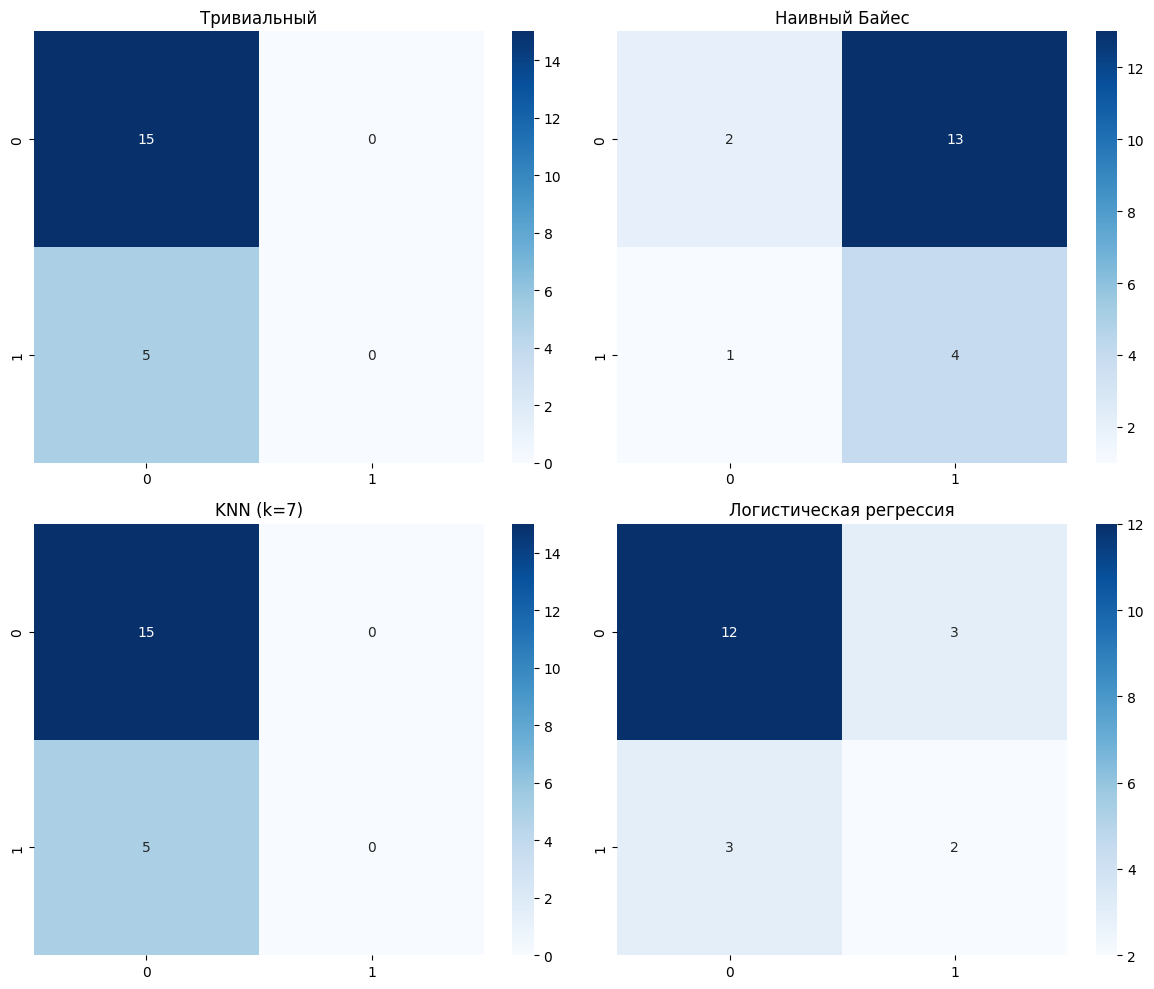

In [23]:
y_proba_lr = lr.predict_proba(X_test_scaled)

results = []
for name, y_pred, y_proba in [
    ('Тривиальный', y_pred_trivial, None),
    ('Наивный Байес', y_pred_nb, y_proba_nb),
    (f'KNN (k={best_k})', y_pred_knn, None),
    ('Логистическая регрессия', y_pred_lr, y_proba_lr)
]:
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'
    }
    results.append(metrics)

# Вывод результатов
print("СРАВНЕНИЕ МОДЕЛЕЙ")
for r in results:
    auc_str = f"{r['ROC-AUC']:.3f}" if r['ROC-AUC'] != 'N/A' else 'N/A'
    print(f"{r['Model']:<20} | Acc: {r['Accuracy']:.3f} | Prec: {r['Precision']:.3f} | "
          f"Rec: {r['Recall']:.3f} | AUC: {auc_str:>5}")

# Матрицы ошибок
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, (y_pred, name) in enumerate([
    (y_pred_trivial, "Тривиальный"),
    (y_pred_nb, "Наивный Байес"), 
    (y_pred_knn, f"KNN (k={best_k})"),
    (y_pred_lr, "Логистическая регрессия")
]):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(name)
plt.tight_layout()
plt.show()

- Precision - это доля правильных предсказаний среди всех объектов, которые модель отнесла к классу True (бюджет). Она равна = TP / (TP + FP).
- Recall (Полнота) - это доля правильно предсказанных объектов класса True среди всех реальных объектов этого класса. Она равна = TP / (TP + FN).
- ROC-AUC - насколько хорошо модель разделяет классы (от 0 до 1 с повышением показателя).

Анализ результатов:

1. Тривиальный классификатор (Acc: 0.750)
- Всегда предсказывает "платная" (наиболее частый класс)
- Precision=0, Recall=0, F1=0 - потому что никогда не предсказывает "бюджет"
- AUC=N/A - нет вероятностей

2. Наивный Байес (Acc: 0.300)
- Слишком часто предсказывает "бюджет" (Recall=0.800)
- Много ложных срабатываний (Precision=0.235)
- Низкая точность, но находит 80% бюджетников

3. KNN (k=7) (Acc: 0.750)
- Фактически превратился в тривиальный классификатор
- Всегда предсказывает "платная" (как и большинство соседей)
- Тот же паттерн метрик: Precision=0, Recall=0, F1=0

4. Логистическая регрессия (Acc: 0.700)
- Балансирует между классами (Precision=0.400, Recall=0.400)
- Пытается предсказывать оба класса
- Хуже точности, но лучше F1-score чем у других

Модели не нашли полезных закономерностей в выбранных признаках для предсказания формы обучения. Лучшая стратегия - всегда говорить "платная" (75% точности). Признаки ['age', 'height', 'cource', 'work_experience', 'score'] слабо связаны с формой обучения.

Матрица ошибок показывает какие именно ошибки делает модель, а не просто общую точность. 

Она состоит из:

            0        1
         ┌───────┬───────┐
       0 │  TN   │  FP   │
         ├───────┼───────┤
       1 │  FN   │  TP   │
         └───────┴───────┘
где

- TN (True Negative) - правильно предсказали "платная" (0)
- FP (False Positive) - ошибочно предсказали "бюджет" вместо "платная"
- FN (False Negative) - ошибочно предсказали "платная" вместо "бюджет"
- TP (True Positive) - правильно предсказали "бюджет" (1)

Общий вывод:
Выбранные признаки слабо предсказывают форму обучения, поэтому даже сложные модели не превосходят простой тривиальный классификатор.